In [53]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

In [2]:
df = load_dataset("lukebarousse/data_jobs")['train'].to_pandas()
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list)

In [43]:
def get_technology(row):
    for tech, skills in row['job_type_skills'].items():
        if row['job_skills'] in skills:
            return tech
    return None

df_DA_US = df[(df['job_country'] == 'United States') & (df['job_title_short'] == 'Data Analyst')].copy()
df_DA_US.dropna(subset='salary_rate', inplace=True)
df_DA_US_exploded = df_DA_US.explode('job_skills')
median_sal = df_DA_US_exploded['salary_year_avg'].median()
# df_DA_US_exploded['salary_year_avg'].fillna(median_sal, inplace=True)
total_jobs = len(df_DA_US)
df_DA_US_skill = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)
df_DA_US_skill.rename(columns= {'count': 'skill_count', 'median': 'median_salary'}, inplace=True)
df_DA_US_skill['percentage'] = df_DA_US_skill['skill_count']/total_jobs *100
df_DA_US_top = df_DA_US_skill[df_DA_US_skill['percentage'] > 5]
df_DA_US_top

,skill_count,median_salary,percentage
job_skills,,,
sql,2508,91000.00,29.708600
excel,1808,84392.00,21.416726
python,1431,97500.00,16.950959
tableau,1364,92875.00,16.157309
sas,926,90000.00,10.968965
r,893,92500.00,10.578062
power bi,838,90000.00,9.926558
powerpoint,462,85000.00,5.472637
word,461,81194.75,5.460791


In [44]:
tech_df = df_DA_US['job_type_skills'].copy().drop_duplicates()
tech_dict = {}
for curr in tech_df:
    if not curr or pd.isna(curr):
        continue
    curr_dict = ast.literal_eval(curr)
    for key, value in curr_dict.items():
        if key in tech_dict:
            tech_dict[key] += value
        else:
            tech_dict[key] = value
for key, value in tech_dict.items():
    tech_dict[key] = list(set(value))
tech_dict
df_tech = pd.DataFrame(list(tech_dict.items()), columns=['technology','skills'])
df_tech = df_tech.explode('skills').copy()
df_tech

,technology,skills
0,analyst_tools,sheets
0,analyst_tools,spreadsheet
0,analyst_tools,cognos
0,analyst_tools,ms access
0,analyst_tools,outlook
...,...,...
9,sync,microsoft teams
9,sync,wire
9,sync,slack
9,sync,twilio


In [58]:
df_plot = df_DA_US_top.merge(df_tech, left_on = 'job_skills', right_on = 'skills')
df_plot

,skill_count,median_salary,percentage,technology,skills
0,2508,91000.00,29.708600,programming,sql
1,1808,84392.00,21.416726,analyst_tools,excel
2,1431,97500.00,16.950959,programming,python
3,1364,92875.00,16.157309,analyst_tools,tableau
4,926,90000.00,10.968965,analyst_tools,sas
5,926,90000.00,10.968965,programming,sas
6,893,92500.00,10.578062,programming,r
7,838,90000.00,9.926558,analyst_tools,power bi
8,462,85000.00,5.472637,analyst_tools,powerpoint
9,461,81194.75,5.460791,analyst_tools,word


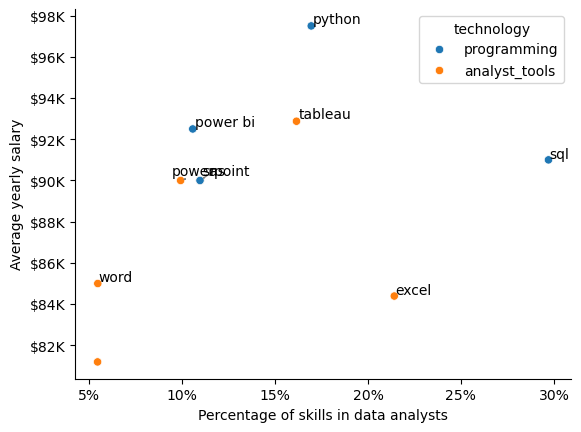

In [69]:
sns.scatterplot(
    df_plot,
    x = 'percentage',
    y = 'median_salary',
    hue = 'technology'
)
sns.despine()
texts = []
for i, txt in enumerate(df_DA_US_top.index):
    texts.append(plt.text(df_plot['percentage'].iloc[i], df_plot['median_salary'].iloc[i], txt))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: f"${int(y/1000)}K"))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.ylabel("Average yearly salary")
plt.xlabel('Percentage of skills in data analysts')
plt.show()

RangeIndex(start=0, stop=10, step=1)